# CoNR: Collaborative Neural Rendering using Anime Character Sheets
![image](https://github.com/megvii-research/CoNR/raw/main/images/MAIN.png)
This project is the official implement of [Collaborative Neural Rendering using Anime Character Sheets](https://arxiv.org/abs/2207.05378), which aims to genarate vivid dancing videos from hand-drawn anime character sheets(ACS). Watch more demos in our [HomePage](https://conr.ml).

Press start on the left of each block, and have fun!

In [ ]:
#@title Setup Repository
#@markdown Clone git repo and install requirements.
!git clone https://github.com/megvii-research/CoNR.git
%cd CoNR
!pip install -r requirements.txt

In [2]:
#@title Download weights
!mkdir weights
%cd weights
!gdown https://drive.google.com/uc?id=1M1LEpx70tJ72AIV2TQKr6NE_7mJ7tLYx
!gdown https://drive.google.com/uc?id=1YvZy3NHkJ6gC3pq_j8agcbEJymHCwJy0
!gdown https://drive.google.com/uc?id=1AOWZxBvTo9nUf2_9Y7Xe27ZFQuPrnx9i
!gdown https://drive.google.com/uc?id=19jM1-GcqgGoE1bjmQycQw_vqD9C5e-Jm

/content/CoNR/weights
Downloading...
From: https://drive.google.com/uc?id=1M1LEpx70tJ72AIV2TQKr6NE_7mJ7tLYx
To: /content/CoNR/weights/rgbadecodernet.pth
100% 342k/342k [00:00<00:00, 53.3MB/s]
Downloading...
From: https://drive.google.com/uc?id=1YvZy3NHkJ6gC3pq_j8agcbEJymHCwJy0
To: /content/CoNR/weights/shader.pth
100% 385M/385M [00:01<00:00, 199MB/s]
Downloading...
From: https://drive.google.com/uc?id=1AOWZxBvTo9nUf2_9Y7Xe27ZFQuPrnx9i
To: /content/CoNR/weights/target_pose_encoder.pth
100% 108M/108M [00:00<00:00, 110MB/s]
Downloading...
From: https://drive.google.com/uc?id=19jM1-GcqgGoE1bjmQycQw_vqD9C5e-Jm
To: /content/CoNR/weights/udpparsernet.pth
100% 229M/229M [00:01<00:00, 146MB/s]


In [3]:
#@title Choose a UDP
#@markdown Choose `double_ponytail` or `short_hair` to use sample UDP sequences. 

#@markdown You can also choose `self_defined`, and upload your own UDP sequences or pose images to `/content/CoNR/poses/`.

UDP = 'double_ponytail' #@param ['double_ponytail', 'short_hair', 'self_defined']

In [ ]:
#@markdown Click start to download sample UDP sequences.
if UDP == 'short_hair':
  %cd ..
  !gdown https://drive.google.com/uc?id=11HMSaEkN__QiAZSnCuaM6GI143xo62KO
  !unzip short_hair.zip
  !mv short_hair/ poses/
  !ls
elif UDP == 'double_ponytail':
  %cd ..
  !gdown https://drive.google.com/uc?id=1WNnGVuU0ZLyEn04HzRKzITXqib1wwM4Q
  !unzip double_ponytail.zip
  !mv double_ponytail/ poses/
  !ls
else:
  print("Please upload your UDP sequences or poses images to /content/CoNR/poses/ .")

In [5]:
#@title Choose a character sheet
#@markdown Choose `double_ponytail` or `short_hair` to use sample character sheets. You can also choose `self_defined`, and upload your own character sheets to `/content/CoNR/character_sheet/`.

#@markdown **Caution**: The character in character sheets should be the same person; also, this character should be **as similar as possible to the one given in the UDP sequence**, otherwise the generated results will be uncontrollable.

#@markdown For example, for short-haired UDPs, short-hair character sheets is recommended.
character = 'double_ponytail' #@param ['double_ponytail', 'short_hair', 'self_defined']

In [ ]:
#@markdown Click start to download sample character sheets.
if character == 'short_hair':
  !gdown https://drive.google.com/uc?id=1r-3hUlENSWj81ve2IUPkRKNB81o9WrwT
  !unzip short_hair_images.zip
  !mv short_hair_images/ character_sheet/
  !ls character_sheet/
elif character == 'double_ponytail':
  !gdown https://drive.google.com/uc?id=1XMrJf9Lk_dWgXyTJhbEK2LZIXL9G3MWc
  !unzip double_ponytail_images.zip
  !mv double_ponytail_images/ character_sheet/
  !ls character_sheet/
else:
  print("Please upload your character sheets to /content/CoNR/character_sheet/")

Num of character sheets: 4


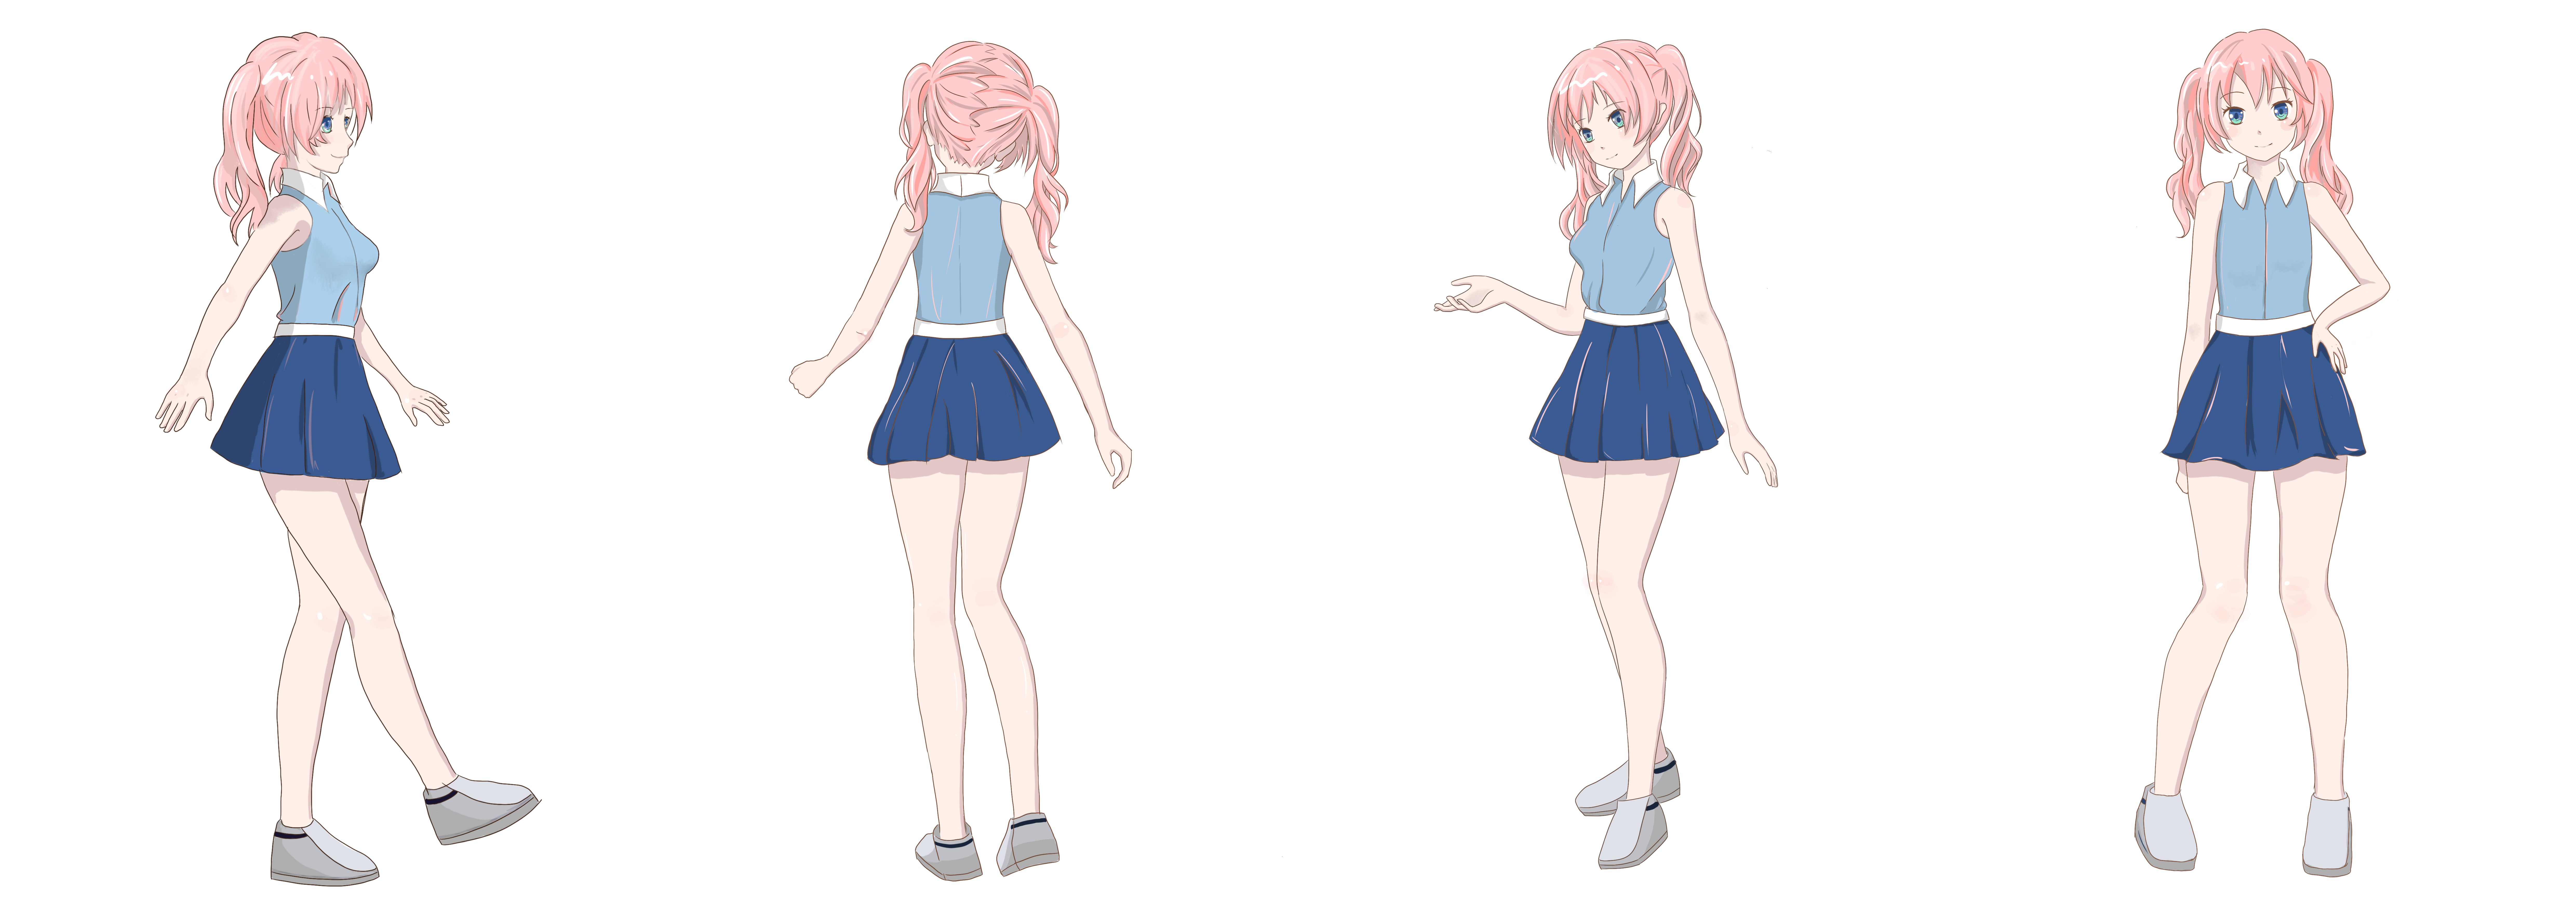

In [10]:
#@title Show all character sheets
import cv2
import numpy as np
import os

path ='/content/CoNR/character_sheet/'
files= os.listdir(path)
imgs = []
for file in files:
     if not os.path.isdir(file):
          img = cv2.imread(path+"/"+file, cv2.IMREAD_UNCHANGED);
          imgs.append(img)
print("Num of character sheets:", len(imgs))
imgs = np.concatenate(imgs, 1)
cv2.imwrite('character_sheet.png', imgs)

from IPython.display import Image
Image(filename='character_sheet.png') 

In [ ]:
#@title RUN!
#@markdown For sample data, this process may take about 40 minutes. You can stop earlier to get an shorter result (by clicking stop on the left).
!mkdir results
!python3 -m torch.distributed.launch \
--nproc_per_node=1 train.py --mode=test \
--world_size=1 --dataloaders=2 \
--test_input_poses_images=./poses/ \
--test_input_person_images=./character_sheet/ \
--test_output_dir=./results/ \
--test_checkpoint_dir=./weights/ 


In [ ]:
#@title Merge generated images into a video
!ffmpeg -r 30 -y -i ./results/%d.png -r 30 -c:v libx264 output.mp4 -r 30

In [13]:
#@title Show video!
from IPython.display import HTML
from base64 import b64encode
 
def show_video(video_path, video_width = 600):
  video_file = open(video_path, "r+b").read()
  video_url = f"data:video/mp4;base64,{b64encode(video_file).decode()}"
  return HTML(f"""<video width={video_width} controls><source src="{video_url}"></video>""")
 
show_video('output.mp4')